# Rayleigh opacities tutorial
This tutorial shows how to create Rayleigh opacity objects and compute their extinction coefficient spectra for a given atmospheric profile.

<div class="alert alert-info">

Note

You can also find this tutorial as a [Python script here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/opacity_rayleigh.py) or as a [jupyter notebook here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/opacity_rayleigh.ipynb).


</div>

In [1]:
# Lets start by importing some useful modules
import pyratbay.atmosphere as pa
#import pyratbay.constants as pc
import pyratbay.spectrum as ps
import pyratbay.opacity as op

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

## 1. Non-parametric models (H, H2, and He)

In [2]:
# We will sample the opacity over a constant-resolution wavelength array
# (boundaries in micron units)
wl_min = 0.2
wl_max = 6.0
resolution = 15000.0
wl = ps.constant_resolution_spectrum(wl_min, wl_max, resolution)

# Models for H, H2, and He based on Dalgarno models (from Kurucz 1970)
H2_rayleigh = op.rayleigh.Dalgarno(wn=1e4/wl, species='H2')

In [3]:
# A print() call shows some useful info about the object:
print(H2_rayleigh)

Model name (name): 'dalgarno_H2'
Model species (species): H2
Number of model parameters (npars): 0
Wavenumber (wn, cm-1):
   [50000.00 49996.67 49993.33 ... 1667.00 1666.88 1666.77]
Cross section (cross_section, cm2 molec-1):
   [7.716e-26 7.714e-26 7.711e-26 ... 6.289e-32 6.287e-32 6.285e-32]



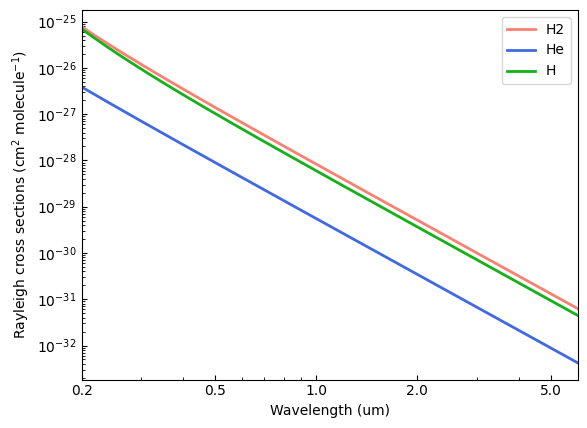

In [4]:
# Show the Rayleigh cross-section spectra
He_rayleigh = op.rayleigh.Dalgarno(wn=1e4/wl, species='He')
H_rayleigh = op.rayleigh.Dalgarno(wn=1e4/wl, species='H')

plt.figure(2)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, H2_rayleigh.cross_section, color='salmon', lw=2.0, label='H2')
ax.plot(wl, He_rayleigh.cross_section, color='royalblue', lw=2.0, label='He')
ax.plot(wl, H_rayleigh.cross_section, color='xkcd:green', lw=2.0, label='H')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlabel('Wavelength (um)')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.2, 0.5, 1.0, 2.0, 5.0])
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Rayleigh cross sections (cm$^{2}$ molecule$^{-1}$)')
ax.legend(loc='upper right')


Compute chemical abundances.


Text(0.5, 0, 'Number density (molecules cm$^{-3}$)')

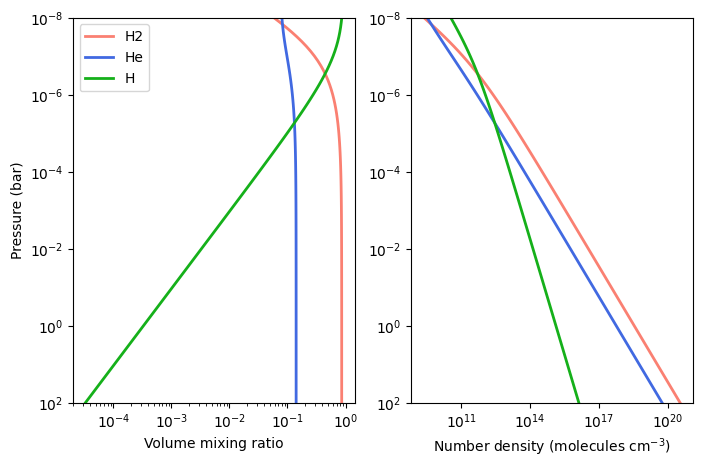

In [5]:
# Now a more practical example, compute the extinction coefficient
# across an atmosphere:

# First, let's consider a simple solar-abundance isothermal atmosphere
nlayers = 81
pressure = pa.pressure('1e-8 bar', '1e2 bar', nlayers)
temperature = np.tile(1800.0, nlayers)

# And a simple thermochemical equilibrium composition (only H2, H, and He)
species = ['H2', 'He', 'H']
composition = pa.chemistry('tea', pressure, temperature, species)
# Number-density profiles under IGL (molecules per cm3)
number_densities = pa.ideal_gas_density(composition.vmr, pressure, temperature)

H2_number_density = number_densities[:,0]
He_number_density = number_densities[:,1]
H_number_density = number_densities[:,2]


# Show profiles:
cols = ['salmon', 'royalblue', 'xkcd:green']
plt.figure(1, (8,5))
plt.clf()
ax = plt.subplot(121)
for i, spec in enumerate(species):
    ax.plot(composition.vmr[:,i], pressure, color=cols[i], lw=2.0, label=spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(100, 1e-8)
ax.set_xlabel('Volume mixing ratio')
ax.set_ylabel('Pressure (bar)')
ax.legend(loc='best')

ax = plt.subplot(122)
for i, spec in enumerate(species):
    ax.plot(number_densities[:,i], pressure, color=cols[i], lw=2.0, label=spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(100, 1e-8)
ax.set_xlabel('Number density (molecules cm$^{-3}$)')

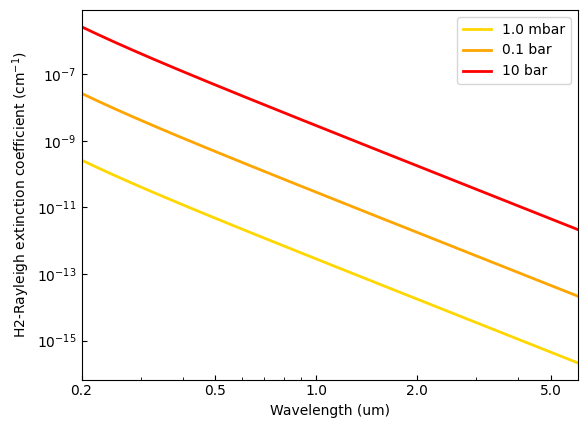

In [6]:
# Calculate extinction-coefficient spectra (cm-1) over the profile
H2_ec = H2_rayleigh.calc_extinction_coefficient(H2_number_density)

plt.figure(2)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, H2_ec[40], color='gold', lw=2.0, label='1.0 mbar')
ax.plot(wl, H2_ec[56], color='orange', lw=2.0, label='0.1 bar')
ax.plot(wl, H2_ec[72], color='red', lw=2.0, label='10 bar')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlabel('Wavelength (um)')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.2, 0.5, 1.0, 2.0, 5.0])
ax.tick_params(which='both', direction='in')
ax.set_ylabel('H2-Rayleigh extinction coefficient (cm$^{-1}$)')
ax.legend(loc='upper right')

## 2. Lecavelier parametric model

In [7]:
# Parametric model based on Lecavelier des Etangs (2008) model for H2:
lec_rayleigh = op.rayleigh.Lecavelier(wn=1e4/wl)

print(lec_rayleigh)

Model name (name): 'lecavelier'
Model species (species): H2
Number of model parameters (npars): 2
Parameter name     Value
  (pnames)         (pars)
  log_k_ray         0.000e+00
  alpha_ray        -4.000e+00
Wavenumber (wn, cm-1):
   [50000.00 49996.67 49993.33 ... 1667.00 1666.88 1666.77]
Cross section (cross_section, cm2 molec-1):
   [ 4.980e-26  4.979e-26  4.978e-26 ...  6.153e-32  6.152e-32  6.150e-32]



Text(0.5, 1.0, 'Lecavelier Rayleigh opacity at 1mbar')

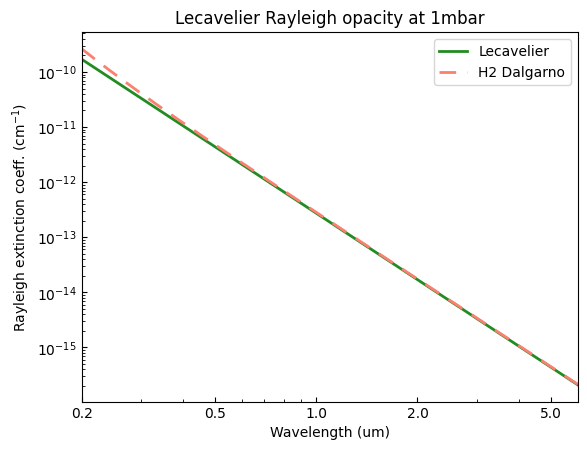

In [8]:
# Evaluate extinction coefficient, with default values it
# reproduces the H2 Rayleigh opacity:
lec_ec = lec_rayleigh.calc_extinction_coefficient(H2_number_density)


# Compare to Dalgarno model:
plt.figure(2)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, lec_ec[40], color='forestgreen', lw=2.0, label='Lecavelier')
ax.plot(wl, H2_ec[40], color='salmon', lw=2.0, dashes=(6,4), label='H2 Dalgarno')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.2, 0.5, 1.0, 2.0, 5.0])
ax.tick_params(which='both', direction='in')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Rayleigh extinction coeff. (cm$^{-1}$)')
ax.legend(loc='upper right')
ax.set_title('Lecavelier Rayleigh opacity at 1mbar')

Text(0.5, 1.0, 'Parametric Rayleigh opacity at 1mbar')

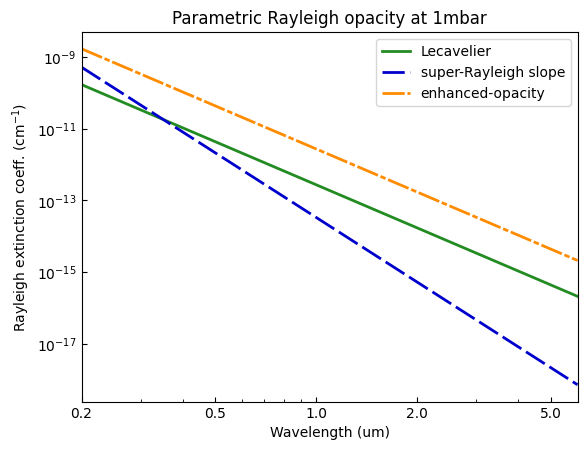

In [9]:
# Evaluate extinction coefficient for different parameter values:
super_ray_ec = lec_rayleigh.calc_extinction_coefficient(
    H2_number_density,
    pars=[0.0, -6.0],
)

enhanced_ray_ec = lec_rayleigh.calc_extinction_coefficient(
    H2_number_density,
    pars=[1.0, -4.0],
)


# See results:
plt.figure(2)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, lec_ec[40], color='forestgreen', lw=2.0, label='Lecavelier')
ax.plot(wl, super_ray_ec[40], color='mediumblue', lw=2.0, dashes=(8,2), label='super-Rayleigh slope')
ax.plot(wl, enhanced_ray_ec[40], color='darkorange', lw=2.0, dashes=(8,1,2,1), label='enhanced-opacity')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.2, 0.5, 1.0, 2.0, 5.0])
ax.tick_params(which='both', direction='in')
ax.set_xlim(np.amin(wl), np.amax(wl))
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Rayleigh extinction coeff. (cm$^{-1}$)')
ax.legend(loc='upper right')
ax.set_title('Parametric Rayleigh opacity at 1mbar')

In [10]:
# Note that once we call calc_extinction_coefficient(), the model
# parameter are updated automatically:
print(lec_rayleigh.pars)

[1.0, -4.0]
